In [1]:
from sklearn.datasets import fetch_20newsgroups
import pickle

# -- Get K-means Cluster Prediction --
from sklearn.cluster import KMeans

# -- Calculate Contingency --
from sklearn.metrics.cluster import contingency_matrix
import numpy as np
# -- Get 5 Measure Scores --
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

from matplotlib import pyplot as plt
import itertools

In [7]:
  
def calculate_contingency(file, true_label):
    if type(file) == str:
        dataset_pred = pickle.load( open( file, "rb" ) )
    else:
        dataset_pred = file
    dataset_contingency = contingency_matrix(true_label,dataset_pred)
    h_score = homogeneity_score(true_label,dataset_pred)
    c_score = completeness_score(true_label,dataset_pred)
    v_score = v_measure_score(true_label,dataset_pred)
    adj_rand_score = adjusted_rand_score(true_label,dataset_pred)
    adj_mutual_score = adjusted_mutual_info_score(true_label,dataset_pred)
    five_measures = {'h_score':h_score,'completeness_score':c_score,'v_measure_score':v_score,'adjusted_rand_score':adj_rand_score,'adjusted_mutual_info_score':adj_mutual_score}
    return dataset_contingency, five_measures


In [8]:
categories = ['comp.sys.ibm.pc.hardware', 'comp.graphics',
              'comp.sys.mac.hardware', 'comp.os.ms-windows.misc',
              'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey']
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

dataset_binary_target = [0 if t<4 else 1 for t in dataset.target]

In [5]:
# -- Get TF-IDF Matrix -- 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = CountVectorizer(min_df=3, stop_words='english')
tfidf = TfidfTransformer(smooth_idf=False)
dataset_doc_term = vectorizer.fit_transform(dataset.data)
dataset_tfidf = tfidf.fit_transform(dataset_doc_term)

print('Dimention of the TF-IDF matrix =', dataset_tfidf.shape)

Dimention of the TF-IDF matrix = (7882, 27768)


In [9]:

#kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30, n_jobs=-1)
kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30, n_jobs=-1)
dataset_kmeans = kmeans.fit_predict(dataset_tfidf)
pickle.dump(dataset_kmeans, open( "problem2_kmeans_wo_dim_reduction.p", "wb" ) )

In [10]:
dataset_contingency, five_measures = calculate_contingency("problem2_kmeans_wo_dim_reduction.p", dataset_binary_target)

In [13]:
def plot_contingency_table(kmeansPredict,true_labels):
    fig, ax = plt.subplots()
    ax.matshow(contingency_matrix(true_labels,kmeansPredict), cmap=plt.cm.Blues)
    plt.xlabel('Class')
    plt.ylabel('Cluster')

    for i in range(2):
        for j in range(2):
            c = contingency_matrix(true_labels,kmeansPredict)[j,i]
            ax.text(i, j, str(c), va = 'center', ha = 'center')

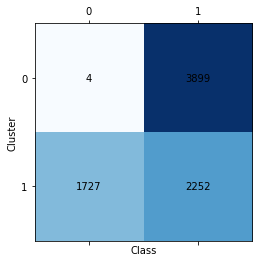

In [14]:
plot_contingency_table(dataset_kmeans,dataset_binary_target)

Question 3: Report the 5 measures above for the K-means clustering results you get.

In [15]:
five_measures
# the score looks low, however, if header and footers are removed, they increased to approx 0.6

{'h_score': 0.25524533029125557,
 'completeness_score': 0.3360642181760738,
 'v_measure_score': 0.29013170035817176,
 'adjusted_rand_score': 0.18270954372564327,
 'adjusted_mutual_info_score': 0.29005781968046146}

QUESTION 4: Report the plot of the percent of variance the top r principle components can retain v.s. r, for r = 1 to 1000.

In [16]:
#-- Apply TruncatedSVD --
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1000, random_state=0)
dataset_tfidf_reduced_svd = svd.fit_transform(dataset_tfidf)
dataset_tfidf_recon_svd = svd.inverse_transform(dataset_tfidf_reduced_svd)
dataset_tfidf_comp_svd = svd.components_
#-- Plot Percent of Variance of The Top r Principle Components --
dataset_singular = svd.singular_values_
dataset_explained_var_ratio = svd.explained_variance_ratio_

Text(0, 0.5, 'cummulative percent of variance (%)')

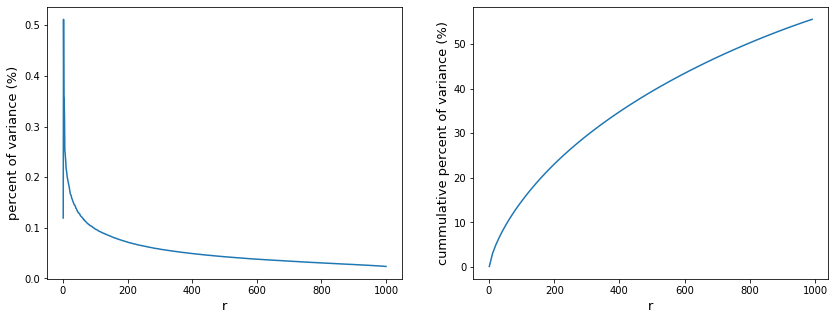

In [17]:
fig = plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(np.arange(1000)+1, dataset_explained_var_ratio*100)
plt.xlabel('r', fontsize=13)
plt.ylabel('percent of variance (%)', fontsize=13)

plt.subplot(122)
r = np.arange(1,1000,10)
cummulative_explained_variance_ratio = [np.sum(dataset_explained_var_ratio[:r_])*100 for r_ in r]
plt.plot(r,cummulative_explained_variance_ratio)
plt.xlabel('r', fontsize=13)
plt.ylabel('cummulative percent of variance (%)', fontsize=13)

QUESTION 5:
Let r be the dimension that we want to reduce the data to (i.e. n components). Try r = 1; 2; 3; 5; 10; 20; 50; 100; 300, and plot the 5 measure scores v.s. r for both SVD and NMF. Report a good choice of r for SVD and NMF respectively.
Note: In the choice of r, there is a trade-off between the information preservation, and better performance of k-means in lower dimensions.

In [24]:
#-- Function to Get and Plot 5 Measure Scores --
from sklearn.decomposition import NMF 

def get_scores(dataset_tfidf, true_label, r_list, num_cluster, reduction_method=None):
    
    method = []
    method_pred = []
    method_score = []
    method_fit_predict = []
    method_print_score = []
    X = []
    kmeans = KMeans(n_clusters=num_cluster, random_state=0, max_iter=1000, n_init=30, n_jobs=-1)

    if reduction_method == 'SVD':
        print('Applying SVD')
        svd = TruncatedSVD(n_components=1000, random_state=0)
        #dataset_tfidf_reduced_svd.shape
        dataset_tfidf_reduced_svd = svd.fit_transform(dataset_tfidf)
        for r in list(r_list) :
            X = dataset_tfidf_reduced_svd[:,:r]
            method.append(X)

    if reduction_method == 'NMF':
        print('Applying NMF')
        for r in list(r_list) :
            print('NMF for r = ' + str(r)+'.')
            nmf = NMF(n_components=r, init='random', random_state=0)
            X = nmf.fit_transform(dataset_tfidf)           
            method.append(X)
            
    for r in range(len(r_list)):
        print('classifying r = '+str(r_list[r])+'.')
        method_fit_predict = kmeans.fit_predict(method[r])       
        dataset_contingency, five_measures = calculate_contingency(method_fit_predict,true_label)
        method_score.append([five_measures['h_score'],five_measures['completeness_score'],five_measures['v_measure_score'],five_measures['adjusted_rand_score'],five_measures['adjusted_mutual_info_score']])
        method_pred.append(method_fit_predict)
        
    method_score = np.asarray(method_score)
    return method, method_pred, method_score

In [25]:
#-- Get 5 measure Scores For NMF And SVD --
#R = [1,2,3,5,10,20]
R = [1,2,3,5,10,20,50,100,300]
# The NMF takes very long time!
NMF_reduced, NMF_pred, NMF_scores = get_scores(dataset_tfidf, dataset_binary_target, R, 2, reduction_method='NMF')
SVD_reduced, SVD_pred, SVD_scores = get_scores(dataset_tfidf, dataset_binary_target, R, 2, reduction_method='SVD')

Applying NMF
NMF for r = 1.
NMF for r = 2.
NMF for r = 3.
NMF for r = 5.
NMF for r = 10.
NMF for r = 20.
classifying r = 0.
classifying r = 1.
classifying r = 2.
classifying r = 3.
classifying r = 4.
classifying r = 5.
Applying SVD
classifying r = 0.
classifying r = 1.
classifying r = 2.
classifying r = 3.
classifying r = 4.
classifying r = 5.


In [33]:
def plot_scores(scores, reduction_method, loc='upper right',figsize=(5,5)):
    
    fig = plt.figure(figsize=figsize)
    plt.clf()
    
    for i in range(5):
        plt.plot(R, scores[:,i], marker=i+2)
    
    plt.legend(['homogeneity score','completeness score', 'v measure score', 
                'adjusted rand score', 'adjusted mutual info score'], loc=loc)
    plt.title('5 Measure Scores for {}'.format(reduction_method))
    plt.xlabel('r')
    plt.ylabel('score')
    plt.show()

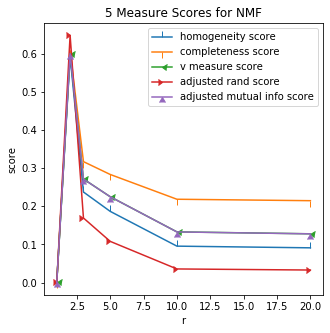

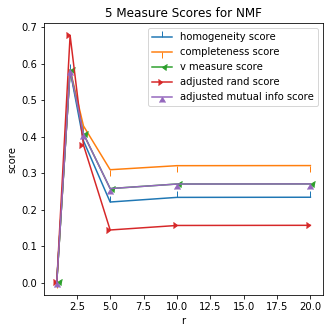

In [35]:
#-- Plot 5 Measure Scores For NMF And SVD --
plot_scores(NMF_scores, reduction_method='NMF',figsize=(5,5))
plot_scores(SVD_scores, reduction_method='NMF',figsize=(5,5))

QUESTION 6: How do you explain the non-monotonic behavior of the measures as r
increases?

An important feature helps in creating clusters while an unimportant feature may not help in creating clusters, and in contrary it may affect the clustering algorithms adversely by blurring the clusters. Unimportant features are noisy or irrelevant and can be removed to reduce the data size for more efficient clustering. 
Hence, the non-monotonic behavior of the measures should be highly related to the importancy of each feature and therefore the curves could be non-monotonic. Besides, as r increases to over 50, the scores don’t vary a lots since those features are not important to the datasets. 

QUESTION 7: Visualize the clustering results for:

SVD with your choice of r

NMF with your choice of r

In [37]:
# -- Get Best r For NMF And SVD --
NMF_reduced_best_, NMF_pred_best_, NMF_score_best_ = get_scores(dataset_tfidf, dataset_binary_target, [2], 2, reduction_method='NMF')
SVD_reduced_best_, SVD_pred_best_, SVD_score_best_= get_scores(dataset_tfidf, dataset_binary_target, [2], 2, reduction_method='SVD')

# -- Get Best r For NMF And SVD --
NMF_reduced_best, NMF_pred_best = NMF_reduced_best_[0], NMF_pred_best_[0]
SVD_reduced_best, SVD_pred_best = SVD_reduced_best_[0], SVD_pred_best_[0]

Applying NMF
NMF for r = 2.
classifying r = 0.
Applying SVD
classifying r = 0.


In [38]:
# -- Function To Plot Scatter Without Transformation --
def plot_scatter(reduced_matrix, true_label, pred_label, method, transformation, num_cluster):
    fig,axes = plt.subplots(1,2,figsize=(12,5))
    axes[0].scatter(reduced_matrix[:,0],reduced_matrix[:,1],c=true_label)
    axes[0].set_title(('{}, '+ transformation +', Ground truth').format(method), fontsize=15)
    axes[1].scatter(reduced_matrix[:,0],reduced_matrix[:,1],c=pred_label)
    axes[1].set_title(('{}, '+ transformation +', Clustering label').format(method),fontsize=15)
    #axes[2].text(0,0,print_score(true_label, pred_label),bbox=dict(facecolor='green', alpha=0.2), fontsize=16)
    #axes[2].axis('off')

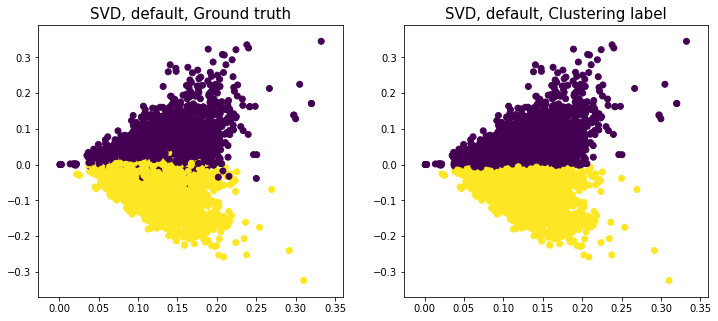

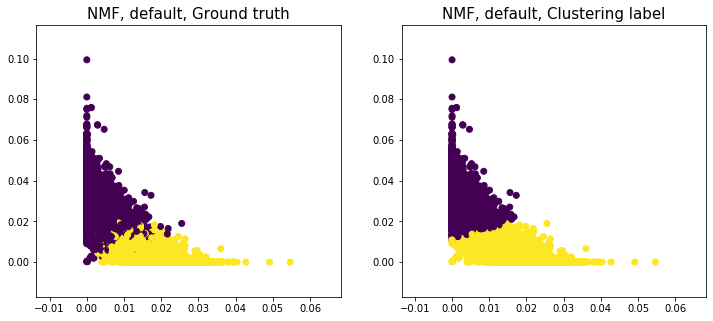

In [39]:
# -- Plot Scatter Without Transformation --    
plot_scatter(SVD_reduced_best, dataset_binary_target, SVD_pred_best,'SVD', 'default', 2)
plot_scatter(NMF_reduced_best, dataset_binary_target, -NMF_pred_best,'NMF', 'default', 2)

In [40]:
dataset_contingency_SVD_r2, five_measures_SVD_r2 = calculate_contingency(SVD_pred_best, dataset_binary_target)
dataset_contingency_NMF_r2, five_measures_NMF_r2 = calculate_contingency(NMF_pred_best, dataset_binary_target)

In [41]:
print(five_measures_SVD_r2)

{'h_score': 0.5814909307607379, 'completeness_score': 0.58397751630097, 'v_measure_score': 0.5827315709032068, 'adjusted_rand_score': 0.6775208075943945, 'adjusted_mutual_info_score': 0.5826932882925123}


In [42]:
print(five_measures_NMF_r2)

{'h_score': 0.5921698279984745, 'completeness_score': 0.6074611210536105, 'v_measure_score': 0.5997180180359933, 'adjusted_rand_score': 0.6477744374238037, 'adjusted_mutual_info_score': 0.5996809046128623}


Question 8) Transformed results

In [43]:
# -- Function To Plot Scatter With Transformed Data --
from sklearn import preprocessing

eta = 0.05
log_transform = lambda X: np.log(X+eta)

def transformation(X,method):
    if method == 'NMF':
        X_unscale_unlog = X
        X_unscale_log = log_transform(X)
        X_scale_unlog = preprocessing.scale(X,with_mean=False)
        X_scale_log = log_transform(preprocessing.scale(X,with_mean=False))
        X_log_scale = (preprocessing.scale(log_transform(X),with_mean=False))
        return X_unscale_unlog, X_unscale_log, X_scale_unlog, X_scale_log,X_log_scale
    
    else:
        X_unscale_unlog = X
        X_scale_unlog = preprocessing.scale(X,with_mean=False)
        return X_unscale_unlog,X_scale_unlog
    
def plot_scatter_transformation(reduced_matrix, true_label, method, num_cluster):
    
    kmeans = KMeans(n_clusters=num_cluster, random_state=0, max_iter=1000, n_init=30, n_jobs=-1)
    # just try the same permutation for SVD
    if method == 'NMF':
        title = ['original','unscale->log', 'scale->unlog', 'scale->log','log->scale']
    else:
        title = ['original','scale & unlog']
        
    for i, X in enumerate(transformation(reduced_matrix,method)):
        X_pred = kmeans.fit_predict(X)
        plot_scatter(X, true_label, X_pred, method, title[i], num_cluster)
        dataset_contingency, five_measures = calculate_contingency(X_pred, true_label)
        print(str(title[i]+':'+str(five_measures)))
        
        
# -- Plot Scatter With Transformed Data --
#plot_scatter_transformation(NMF_reduced_best, dataset_binary_target,'NMF',2)

original:{'h_score': 0.5814909307607379, 'completeness_score': 0.58397751630097, 'v_measure_score': 0.5827315709032068, 'adjusted_rand_score': 0.6775208075943945, 'adjusted_mutual_info_score': 0.5826932882925123}
scale & unlog:{'h_score': 0.22490651189940575, 'completeness_score': 0.25498697762238776, 'v_measure_score': 0.23900399971656083, 'adjusted_rand_score': 0.23998529277795425, 'adjusted_mutual_info_score': 0.23892995935251687}


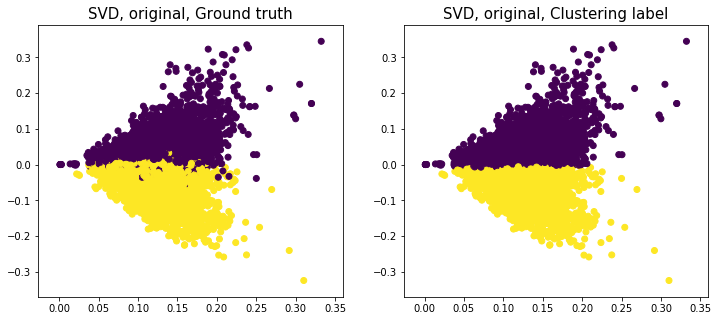

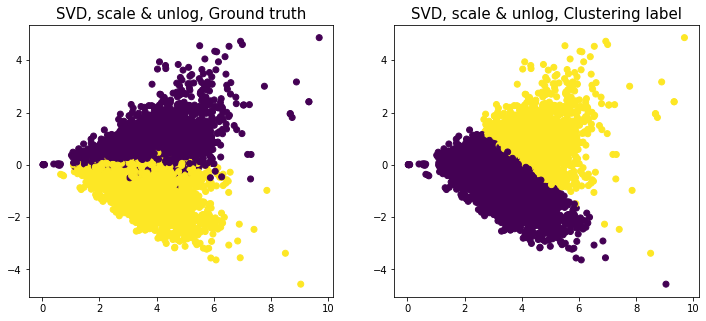

In [44]:
plot_scatter_transformation(SVD_reduced_best, dataset_binary_target,'SVD',2)

original:{'h_score': 0.5921698279984745, 'completeness_score': 0.6074611210536105, 'v_measure_score': 0.5997180180359933, 'adjusted_rand_score': 0.6477744374238037, 'adjusted_mutual_info_score': 0.5996809046128623}
unscale->log:{'h_score': 0.6652131112878659, 'completeness_score': 0.6713001019954047, 'v_measure_score': 0.6682427454034876, 'adjusted_rand_score': 0.7451384368288277, 'adjusted_mutual_info_score': 0.6682122344948273}
scale->unlog:{'h_score': 0.6836879320616037, 'completeness_score': 0.6864952583546969, 'v_measure_score': 0.6850887192858025, 'adjusted_rand_score': 0.774335686170411, 'adjusted_mutual_info_score': 0.6850598299531877}
scale->log:{'h_score': 0.7163410081782867, 'completeness_score': 0.7163435702230417, 'v_measure_score': 0.7163422891983734, 'adjusted_rand_score': 0.8123072196731287, 'adjusted_mutual_info_score': 0.7163163202089291}
log->scale:{'h_score': 0.6933500843860649, 'completeness_score': 0.6953071161603254, 'v_measure_score': 0.6943272212527414, 'adjust

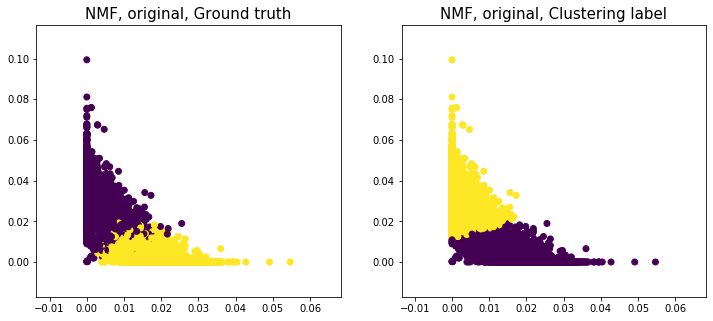

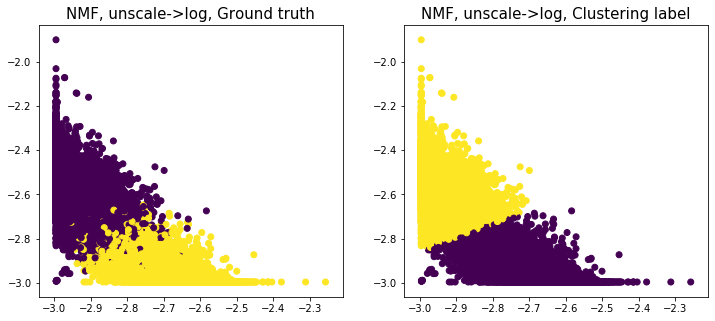

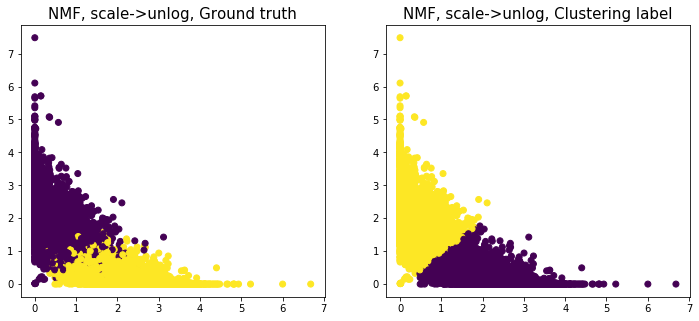

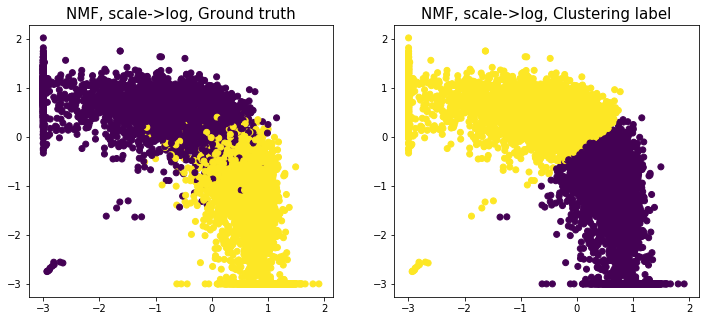

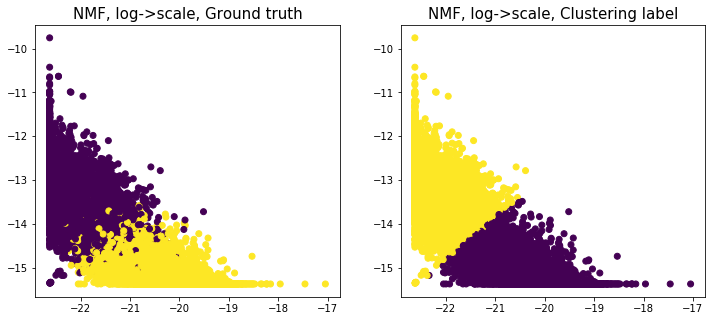

In [45]:
plot_scatter_transformation(NMF_reduced_best, dataset_binary_target,'NMF',2)